In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [19]:
def repair_dates(df):
    df['date_range_start'] = pd.to_datetime(df['date_range_start'], utc=True)
    df['date_range_start'] = df['date_range_start'].dt.tz_convert('US/Eastern')

In [21]:
home_df = pd.read_csv(f'./exports/home_weekly.csv')
repair_dates(home_df)
home_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360050001000,4,0.000000,0.500000,0.000000,0.000000
1,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041
2,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470493005,4,8.588745,0.020101,0.020101,2.316296
3,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471134003,4,2.479008,0.008333,0.008333,0.668563
4,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360471196002,4,0.212593,0.001224,0.001224,0.057334


In [28]:
cdi_total_df = home_df.groupby(by=['date_range_start']).agg({'cdi': 'sum'}).reset_index()
cdi_total_df = cdi_total_df.sort_values(by=['date_range_start'])
cdi_total_df.head()

,date_range_start,cdi
0,2018-12-31 00:00:00-05:00,390609.769407
1,2019-01-07 00:00:00-05:00,630125.134950
2,2019-01-14 00:00:00-05:00,380460.447928
3,2019-01-21 00:00:00-05:00,241184.376961
4,2019-01-28 00:00:00-05:00,281566.233464


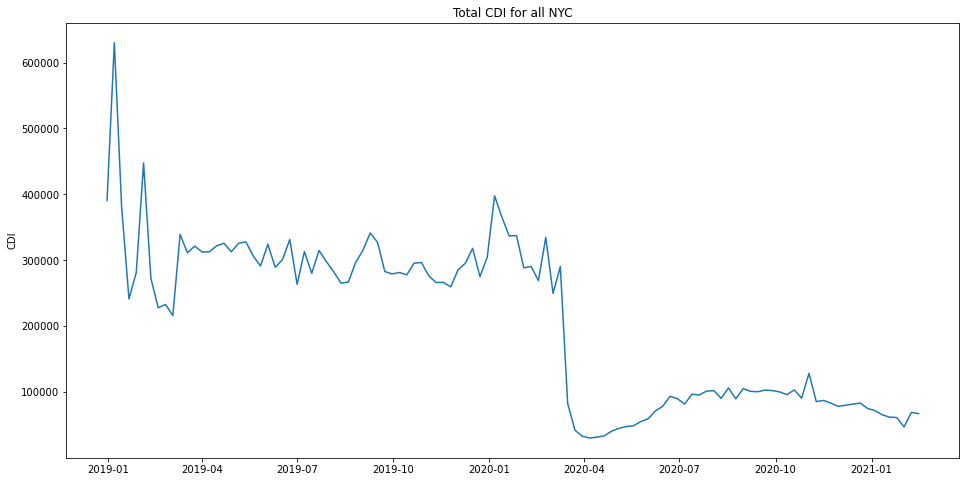

In [23]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_total_df['date_range_start'], cdi_total_df['cdi'])
ax.set_title('Total CDI for all NYC')
ax.set_ylabel('CDI')
plt.show()

In [146]:
def create_diff_df(cdi_df, keep_columns=[]):
    cdi_week_df = cdi_df
    cdi_week_df['year'] = cdi_week_df['date_range_start'].dt.year
    cdi_week_df['week'] = cdi_week_df['date_range_start'].dt.week
    
    # Dates are missing from December 2020!
    display(cdi_week_df.iloc[95:105])
    
    cdi_2020_df = cdi_week_df[cdi_week_df['year'] == 2020]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] >= 2]
    cdi_2020_df = cdi_2020_df[cdi_2020_df['week'] <= 52].reset_index(drop=True)
    cdi_2019_df = cdi_week_df[cdi_week_df['year'] == 2019]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] >= 2]
    # Remove dates that can't be compared.
    cdi_2019_df = cdi_2019_df[~cdi_2019_df['week'].isin(set([50, 51]))]
    cdi_2019_df = cdi_2019_df[cdi_2019_df['week'] <= 52].reset_index(drop=True)
    
    display(cdi_2019_df.head())
    display(cdi_2020_df.head())
    
    cdi_diff_df = cdi_2020_df[['cdi']] - cdi_2019_df[['cdi']]
    for keep_column in (keep_columns + ['week', 'date_range_start']):
        cdi_diff_df[keep_column] = cdi_2020_df[keep_column]
    
    display(cdi_diff_df.head())
    
    return cdi_diff_df

In [149]:
cdi_diff_df = create_diff_df(cdi_total_df)

,date_range_start,cdi,year,week
95,2020-10-26 00:00:00-04:00,90678.073482,2020,44
96,2020-11-02 00:00:00-05:00,128439.081674,2020,45
97,2020-11-09 00:00:00-05:00,85513.766503,2020,46
98,2020-11-16 00:00:00-05:00,87220.032151,2020,47
99,2020-11-23 00:00:00-05:00,83207.553610,2020,48
100,2020-11-30 00:00:00-05:00,78358.964352,2020,49
101,2020-12-21 00:00:00-05:00,83301.524784,2020,52
102,2020-12-28 00:00:00-05:00,75156.680390,2020,53
103,2021-01-04 00:00:00-05:00,71920.651448,2021,1
104,2021-01-11 00:00:00-05:00,65611.861707,2021,2


,date_range_start,cdi,year,week
0,2019-01-07 00:00:00-05:00,630125.134950,2019,2
1,2019-01-14 00:00:00-05:00,380460.447928,2019,3
2,2019-01-21 00:00:00-05:00,241184.376961,2019,4
3,2019-01-28 00:00:00-05:00,281566.233464,2019,5
4,2019-02-04 00:00:00-05:00,447745.305585,2019,6


,date_range_start,cdi,year,week
0,2020-01-06 00:00:00-05:00,397835.725201,2020,2
1,2020-01-13 00:00:00-05:00,365517.475701,2020,3
2,2020-01-20 00:00:00-05:00,336945.433057,2020,4
3,2020-01-27 00:00:00-05:00,337471.777632,2020,5
4,2020-02-03 00:00:00-05:00,288427.870884,2020,6


,cdi,week,date_range_start
0,-232289.409749,2,2020-01-06 00:00:00-05:00
1,-14942.972227,3,2020-01-13 00:00:00-05:00
2,95761.056096,4,2020-01-20 00:00:00-05:00
3,55905.544168,5,2020-01-27 00:00:00-05:00
4,-159317.434700,6,2020-02-03 00:00:00-05:00


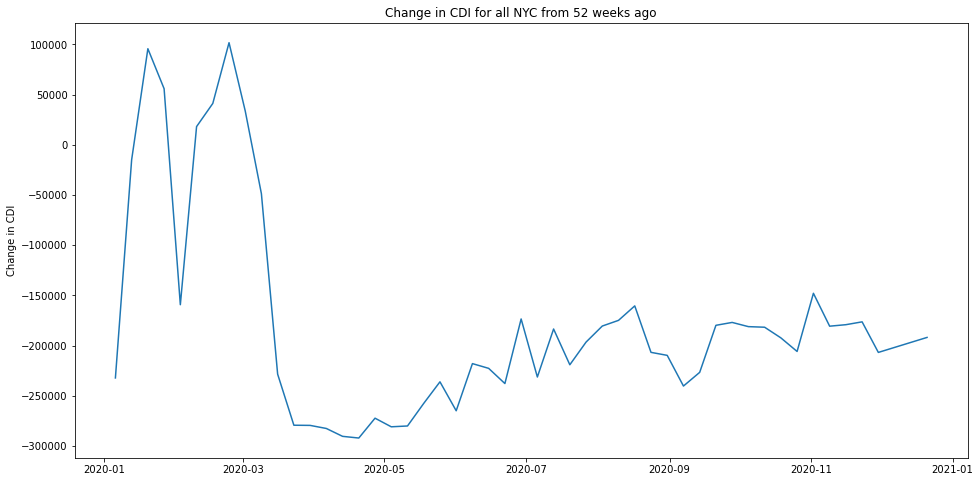

In [144]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(cdi_diff_df['date_range_start'], cdi_diff_df['cdi'])
ax.set_title('Change in CDI for all NYC from 52 weeks ago')
ax.set_ylabel('Change in CDI')
plt.show()

In [139]:
cbg_df = pd.read_csv('./data/cbg_attr_and_cluster_1021.csv')
cbg_df = cbg_df.rename(columns={
    'census_block_group': 'home_cbg',
    'Cluster': 'cluster',
    'Total Population': 'population',
})
cbg_df = cbg_df[['home_cbg', 'cluster', 'population']]
cbg_df.head()

,home_cbg,cluster,population
0,360050001001,2,6864
1,360050002001,2,1744
2,360050002002,2,1569
3,360050002003,3,1219
4,360050004001,3,598


In [135]:
cluster_df = cbg_df.groupby(by=['cluster']).agg({'population': 'sum'}).reset_index()
cluster_df

,cluster,population
0,0,1499585
1,1,1883329
2,2,2079876
3,3,2481612


In [136]:
merge_df = home_df.merge(cbg_df, how='inner', on=['home_cbg'])
merge_df.head()

,placekey,date_range_start,home_cbg,visitor_count,estimated_visitor_count,pct_visitor_count,pct_estimated_visitor_count,cdi,cluster,population,borough
0,22t-222@627-s7m-rtv,2018-12-31 00:00:00-05:00,360470437004,4,9.974576,0.018433,0.018433,2.690041,2,1177,Brooklyn
1,zzw-225@627-s7r-7dv,2020-09-28 00:00:00-04:00,360470437004,4,20.740088,0.031746,0.031746,0.022657,2,1177,Brooklyn
2,222-222@627-wbt-jgk,2019-04-15 00:00:00-04:00,360470437004,4,9.707216,0.019231,0.019231,0.096981,2,1177,Brooklyn
3,222-225@627-s4m-w8v,2019-08-19 00:00:00-04:00,360470437004,4,12.455026,0.022099,0.022099,0.000000,2,1177,Brooklyn
4,zzy-223@627-s8k-3kf,2020-01-27 00:00:00-05:00,360470437004,4,16.068259,0.029630,0.029630,20.978254,2,1177,Brooklyn


In [137]:
cdi_cluster_df = merge_df.groupby(by=['date_range_start', 'cluster']).agg({'cdi': 'sum'}).reset_index()
cdi_cluster_df = cdi_cluster_df.merge(cluster_df, how='outer', on=['cluster'])
cdi_cluster_df = cdi_cluster_df.sort_values(by=['date_range_start', 'cluster'])
cdi_cluster_df['cdi_per_capita'] = cdi_cluster_df['cdi'] / cdi_cluster_df['population']
cdi_cluster_df.head()

,date_range_start,cluster,cdi,population,cdi_per_capita
0,2018-12-31 00:00:00-05:00,0,72006.694403,1499585,0.048018
110,2018-12-31 00:00:00-05:00,1,84936.877159,1883329,0.045099
220,2018-12-31 00:00:00-05:00,2,98888.944000,2079876,0.047546
330,2018-12-31 00:00:00-05:00,3,116719.350809,2481612,0.047034
1,2019-01-07 00:00:00-05:00,0,136418.969305,1499585,0.090971


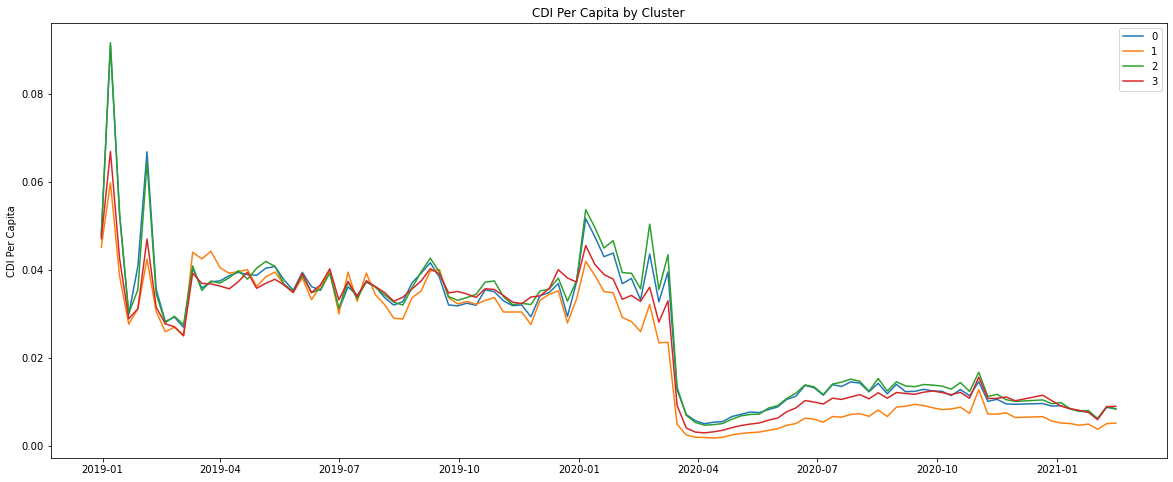

In [138]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('CDI Per Capita by Cluster')
ax.set_ylabel('CDI Per Capita')
ax.legend()
plt.show()

In [153]:
cdi_cluster_diff_df = create_diff_df(cdi_cluster_df, keep_columns=['cluster', 'cdi_per_capita'])

,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
353,2019-06-10 00:00:00-04:00,3,86226.251212,2481612,0.034746,2019,24
24,2019-06-17 00:00:00-04:00,0,52990.344471,1499585,0.035337,2019,25
134,2019-06-17 00:00:00-04:00,1,68383.927919,1883329,0.036310,2019,25
244,2019-06-17 00:00:00-04:00,2,73917.817744,2079876,0.035540,2019,25
354,2019-06-17 00:00:00-04:00,3,90846.706139,2481612,0.036608,2019,25
25,2019-06-24 00:00:00-04:00,0,59550.306633,1499585,0.039711,2019,26
135,2019-06-24 00:00:00-04:00,1,74556.319286,1883329,0.039588,2019,26
245,2019-06-24 00:00:00-04:00,2,81461.179645,2079876,0.039166,2019,26
355,2019-06-24 00:00:00-04:00,3,99723.470276,2481612,0.040185,2019,26
26,2019-07-01 00:00:00-04:00,0,46350.834356,1499585,0.030909,2019,27


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2019-01-07 00:00:00-05:00,0,136418.969305,1499585,0.090971,2019,2
1,2019-01-07 00:00:00-05:00,1,112502.921952,1883329,0.059736,2019,2
2,2019-01-07 00:00:00-05:00,2,190407.727263,2079876,0.091548,2019,2
3,2019-01-07 00:00:00-05:00,3,165809.099007,2481612,0.066815,2019,2
4,2019-01-14 00:00:00-05:00,0,78872.563747,1499585,0.052596,2019,3


,date_range_start,cluster,cdi,population,cdi_per_capita,year,week
0,2020-01-06 00:00:00-05:00,0,77347.383760,1499585,0.051579,2020,2
1,2020-01-06 00:00:00-05:00,1,78861.245119,1883329,0.041873,2020,2
2,2020-01-06 00:00:00-05:00,2,111526.418640,2079876,0.053622,2020,2
3,2020-01-06 00:00:00-05:00,3,112855.020982,2481612,0.045476,2020,2
4,2020-01-13 00:00:00-05:00,0,71205.342717,1499585,0.047483,2020,3


,cdi,cluster,cdi_per_capita,week,date_range_start
0,-59071.585545,0,0.051579,2,2020-01-06 00:00:00-05:00
1,-33641.676834,1,0.041873,2,2020-01-06 00:00:00-05:00
2,-78881.308623,2,0.053622,2,2020-01-06 00:00:00-05:00
3,-52954.078025,3,0.045476,2,2020-01-06 00:00:00-05:00
4,-7667.221030,0,0.047483,3,2020-01-13 00:00:00-05:00


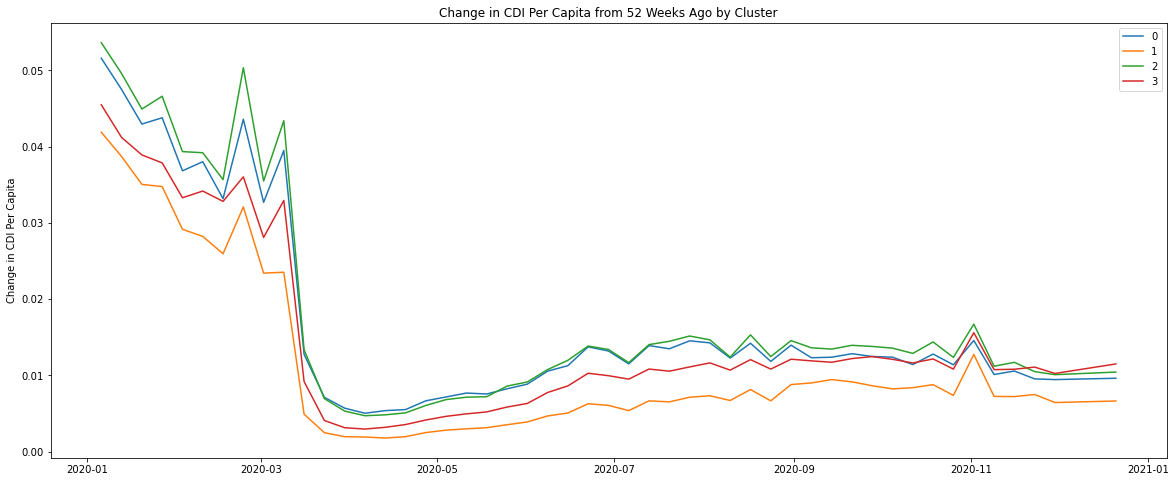

In [154]:
fig, ax = plt.subplots(figsize=(20, 8))
for key, group in cdi_cluster_diff_df.groupby(by=['cluster']):
    ax.plot(group['date_range_start'], group['cdi_per_capita'], label=key)
ax.set_title('Change in CDI Per Capita from 52 Weeks Ago by Cluster')
ax.set_ylabel('Change in CDI Per Capita')
ax.legend()
plt.show()